In [1]:
import diffprivlib as dp
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklego.metrics import p_percent_score #demographic parity
from sklego.metrics import equal_opportunity_score #equal opportunity
from sklearn.metrics import accuracy_score
import numpy as np
np.random.seed(31415)
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
def get_classifier(cls_str, diffpriv=True, bounds=None, epsilon=None, acc=None):
    '''

    :param cls_str: one of ['NB', 'LR', 'RF']
    :param diffpriv:Whether dp classifier or regular classifier
    :param bounds:  Bounds of the data, provided as a tuple of the form (min, max).
                    min and max can either be scalars, covering the min/max of the
                    entire data, or vectors with one entry per feature. If not
                    provided, the bounds are computed on the data when .fit() is
                    first called, resulting in a PrivacyLeakWarning
    :param epsilon: Privacy parameter for the model. default: 1.0
    :param acc:     Accountant to keep track of privacy budget
    :return:        The classifier instantiated
    '''

    if(cls_str == 'NB' and diffpriv == True):
        return dp.models.GaussianNB(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'NB' and diffpriv == False):
        return GaussianNB()
    
    elif(cls_str == 'LR' and diffpriv == True):
        return dp.models.LogisticRegression(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'LR' and diffpriv == False):
        return LogisticRegression(random_state=0)
    
    elif(cls_str == 'RF' and diffpriv == True):
        return dp.models.RandomForestClassifier(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'RF' and diffpriv == False):
        return RandomForestClassifier(random_state=0)
    
    else:
        print("Incorrect Classifier - must be one of ['NB', 'LR', 'RF']")
        return

In [3]:
from math import floor
def test_train_split(df,label_col):
    test_frac = 0.2
    train_frac = 1 - test_frac
    train_size = floor(len(df)*train_frac)
    test_size = len(df) - train_size
    s_df = df.sample(frac=1,random_state=23)
    X_train = df.loc[:, df.columns != label_col][:train_size]
    y_train = df.loc[:,label_col][:train_size]
    X_test = df.loc[:, df.columns != label_col][train_size:len(df)]
    y_test = df.loc[:, label_col][train_size:len(df)]
    return X_train, y_train, X_test, y_test

# Load hosuing data

In [98]:
# save separate files for test training
fm_2020 = pd.read_pickle('../../data/fm_2020_all.gz')

In [97]:
fm_2020.dtypes

1       int32
2       int32
3       int32
4       int32
5       int32
       ...   
13    float64
36    float64
42    float64
46    float64
53    float64
Length: 64, dtype: object

In [66]:
fm_frac = fm_2020.sample(frac=1,random_state=31415)

In [94]:
fm_2020.shape

(4857624, 64)

In [95]:
out = []
idx_cols = [1,2]
geo_cols = 
float_cols = [7,10,13,36,42,46,53]
for c in fm_2020.columns:
    if c not in float_cols:
        out.append([c,len(fm_frac[c].unique())])

In [96]:
pd.DataFrame(data=out,columns = ['col','n_unique']).sort_values('n_unique',ascending=False)

,col,n_unique
4,8,38581
3,6,23538
44,54,17254
6,11,2601
5,9,1250
47,57,534
7,12,440
1,4,394
2,5,324
36,44,265


In [33]:
bins = np.arange(1.5,7.5,0.5)
fm_ir_bins = pd.cut(fm_frac.loc[:,46],bins=bins,labels=False,include_lowest=True)

In [34]:
fm_frac['ir_bin'] = fm_ir_bins.apply(lambda x: bins[x])

In [62]:
# remove 1 & 2 - index fields
# remove 46 - interest rate (label)
model_data = fm_frac.loc[:,
    (fm_frac.columns != 1) & (fm_frac.columns != 2) & (fm_frac.columns != 46)
]
full_len = len(model_data)

# filter data to get gender a binary column - male (1) and female (2)
# male = 0, female = 1
model_data = model_data.loc[(model_data[31] == 1) | (model_data[31] == 1)]
model_data[31] = model_data[31].replace(1, 0).replace(2, 1)

# filter data to get race a binary column - white (3) and black (5)
# black = 0, white = 1
model_data = model_data.loc[(model_data[25] == 3) | (model_data[25] == 5)]
model_data[25] = model_data[25].replace(5, 0).replace(3, 1)

print(len(model_data)/full_len)
X_train, y_train, X_test, y_test = test_train_split(model_data,'ir_bin')

0.27095573552480434


In [12]:
nb = get_classifier('NB',diffpriv=False)

In [13]:
dp_nb = get_classifier('NB',epsilon=0.1)

In [14]:
dp_nb.fit(X_train, y_train.astype('str'))

GaussianNB(accountant=BudgetAccountant(spent_budget=[(0.1, 0)]),
           bounds=(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.934e+04,
       0.000e+00, 1.820e+04, 5.000e+03, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1....
       1.000000e+00, 9.000000e+00, 9.000000e+00, 2.000000e+00,
       3.600000e+02, 4.000000e+00, 1.475000e+06, 9.000000e+00,
       9.000000e+00, 9.000000e+00, 9.000000e+00, 1.000000e+01,
       1.050000e+06, 9.990000e+02, 9.000000e+00, 3.820050e+08,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 9.999000e+03,
       9.999000e+03, 2.027042e+02, 6.790000e+00, 1.190000e+02,
       9.900000e+01])),
           epsilon=0.1)

In [15]:
dp_nb_preds = dp_nb.predict(X_test)

In [16]:
accuracy_score(dp_nb_preds,y_test.astype('str'))

0.3593288901469339

In [17]:
dp_nb_1 = get_classifier('NB',epsilon=1)

In [18]:
dp_nb_1.fit(X_train, y_train.astype('str'))

GaussianNB(accountant=BudgetAccountant(spent_budget=[(0.1, 0), (1, 0)]),
           bounds=(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.934e+04,
       0.000e+00, 1.820e+04, 5.000e+03, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e...
       1.000000e+00, 9.000000e+00, 9.000000e+00, 2.000000e+00,
       3.600000e+02, 4.000000e+00, 1.475000e+06, 9.000000e+00,
       9.000000e+00, 9.000000e+00, 9.000000e+00, 1.000000e+01,
       1.050000e+06, 9.990000e+02, 9.000000e+00, 3.820050e+08,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 1.000000e+00,
       1.000000e+00, 1.000000e+00, 1.000000e+00, 9.999000e+03,
       9.999000e+03, 2.027042e+02, 6.790000e+00, 1.190000e+02,
       9.900000e+01])),
           epsilon=1)

In [19]:
dp_nb_1_preds = dp_nb_1.predict(X_test)

In [20]:
accuracy_score(dp_nb_1_preds,y_test.astype('str'))

0.3956727824811508

In [21]:
nb.fit(X_train, y_train.astype('str'))

GaussianNB()

In [97]:
nb_preds = nb.predict(X_test)

In [98]:
accuracy_score(nb_preds,y_test.astype('str'))

0.20148631539942152

In [100]:
sorted(y_test.unique())

[1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

### Plot classifier params

In [63]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value        
    return smoothed


def plot_params(X_train, y_train, X_test, y_test, num_trials, cls_str, sex_col='Sex', race_col='Race'):
    
    eps_list = np.logspace(-2, 2, 10)
    acc_list = []
    dem_parity_list_gender = []
    dem_parity_list_race = []
    eq_opp_list_gender = []
    eq_opp_list_race = []
    acc_score = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_gender = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_race = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_gender = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_race = np.zeros((num_trials, len(eps_list)))

    for i in tqdm(range(num_trials)):    
        for j,eps in enumerate(eps_list):
            clf = get_classifier(cls_str, diffpriv=True, epsilon=eps)
            clf.fit(X_train,y_train)
#             import pdb; pdb.set_trace()
            acc_score[i,j] = clf.score(X_test, y_test)
            # fairness metrics need the sensitive column to be binary {0,1}. Cannot normalize!
            dem_parity_score_gender[i,j] = p_percent_score(sensitive_column=sex_col)(clf, X_train)
            dem_parity_score_race[i,j] = p_percent_score(sensitive_column=race_col)(clf, X_train)
            eq_opp_score_gender[i,j] = equal_opportunity_score(sensitive_column=sex_col)(clf, X_train, y_train)
            eq_opp_score_race[i,j] = equal_opportunity_score(sensitive_column=race_col)(clf, X_train, y_train)

    clf = get_classifier(cls_str, diffpriv=False)
    clf.fit(X_train,y_train)
    acc = clf.score(X_test, y_test)
    dp_g = p_percent_score(sensitive_column=sex_col)(clf, X_train)
    dp_r = p_percent_score(sensitive_column=race_col)(clf, X_train)
    eo_g = equal_opportunity_score(sensitive_column=sex_col)(clf, X_train, y_train)
    eo_r = equal_opportunity_score(sensitive_column=race_col)(clf, X_train, y_train)
    
    acc_list = np.mean(acc_score, axis=0)        
    dem_parity_list_gender = np.mean(dem_parity_score_gender, axis=0)
    dem_parity_list_race = np.mean(dem_parity_score_race, axis=0)
    eq_opp_list_gender = np.mean(eq_opp_score_gender, axis=0)
    eq_opp_list_race = np.mean(eq_opp_score_race, axis=0)
    
    plt.suptitle(cls_str + ' Classifier Accuracy and Fairness Metrics vs Epsilon') 
    plt.title('Dashed and Solid Lines for Standard and Private Classifiers', fontsize='small')
    plt.axhline(acc, color='r', linestyle='--')
    plt.axhline(dp_g, color='g', linestyle='--')
    plt.axhline(dp_r, color='b', linestyle='--')
    plt.axhline(eo_g, color='m', linestyle='--')
    plt.axhline(eo_r, color='y', linestyle='--')   
    
    plt.semilogx(eps_list, smooth(acc_list,0.9), label='Accuracy', color='r')
    plt.semilogx(eps_list, smooth(dem_parity_list_gender,0.9), label='Dem Par Gender', color='g')
    plt.semilogx(eps_list, smooth(dem_parity_list_race,0.9), label='Dem Par Race', color='b')
    plt.semilogx(eps_list, smooth(eq_opp_list_gender,0.9), label='Eq Opp Gender', color='m')
    plt.semilogx(eps_list, smooth(eq_opp_list_race,0.9), label='Eq Opp Gender', color='y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(0,1)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy / Fairness')
    
    plt.savefig('plots/'+cls_str+'.png', dpi=75)
    plt.show()
    return {
        ''
    }

100%|██████████| 50/50 [22:24<00:00, 26.89s/it]


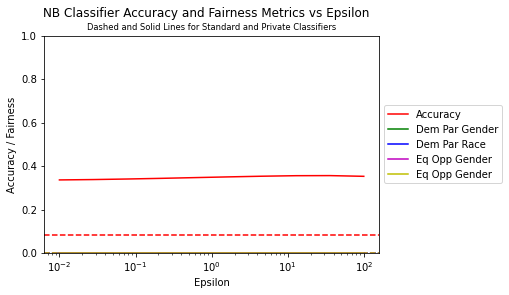

In [64]:
plot_params(
    X_train, 
    y_train.astype('str'), 
    X_test, 
    y_test.astype('str'), 
    50, 
    'NB', 
    sex_col=31,
    race_col=25)

100%|███████████████████████████████████████████| 50/50 [10:21<00:00, 12.43s/it]


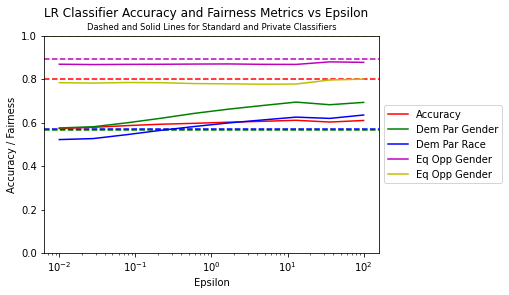

In [10]:
plot_params(X_train, y_train, X_test, y_test, 50, 'LR')

## Varuns stuff below
____________________

# Preprocess Income Data

In [3]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

train_url = '../data/income/adult.data'
# 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = '../data/income/adult.test'
# 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
original_train = original_train[(original_train['Race']=='Black') | (original_train['Race'] == 'White')]

# 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)
original_test = original_test[(original_test['Race']=='Black') | (original_test['Race'] == 'White')]

num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)
# Redundant column, Education-Num is already present
del original["Education"]
# Remove target variable since we've already binarized to labels variable
del original["Target"]
original.Sex = original.Sex.replace({'Male': 1, 'Female': 0})
original.Race = original.Race.replace({'White': 1, 'Black': 0})

#binarize all the categorical values
binary_data = pd.get_dummies(original) # n x 13 -> n x 83

X_train = binary_data[:num_train]
y_train = labels[:num_train]
X_test = binary_data[num_train:]
y_test = labels[num_train:]

# Data Distribution

In [4]:
n1 = len(original_train[ (original_train['Race']=='Black') & (original_train['Target'] == '<=50K')])
n2 = len(original_train[(original_train['Race']=='Black') & (original_train['Target'] == '>50K')])
n3 = len(original_train[(original_train['Race']=='White') & (original_train['Target'] == '<=50K')])
n4 = len(original_train[(original_train['Race']=='White') & (original_train['Target'] == '>50K')])
n5 = len(original_train[(original_train['Sex']=='Female') & (original_train['Target'] == '<=50K')])
n6 = len(original_train[(original_train['Sex']=='Female') & (original_train['Target'] == '>50K')])
n7 = len(original_train[(original_train['Sex']=='Male') & (original_train['Target'] == '<=50K')])
n8 = len(original_train[(original_train['Sex']=='Male') & (original_train['Target'] == '>50K')])

black_perc = (n1+n2)/num_train
black_0 = n1/num_train
black_1 = n2/num_train

white_perc = (n3+n4)/num_train
white_0 = n3/num_train
white_1 = n4/num_train

female_perc = (n5+n6)/num_train
female_0 = n5/num_train
female_1 = n6/num_train

male_perc = (n7+n8)/num_train
male_0 = n7/num_train
male_1 = n8/num_train

print(black_perc, black_0, black_1)
print(white_perc, white_0, white_1)
print(female_perc, female_0, female_1)
print(male_perc, male_0, male_1)

0.10096961861667744 0.08846153846153847 0.01250808015513898
0.8990303813833226 0.6690045248868778 0.23002585649644472
0.3295733678086619 0.29343891402714933 0.03613445378151261
0.670426632191338 0.464027149321267 0.2063994828700711


In [5]:
total_black = len(original_train[original_train['Race']=='Black'])
total_white = len(original_train[original_train['Race']=='White'])
total_male = len(original_train[original_train['Sex']=='Male'])
total_female = len(original_train[original_train['Sex']=='Female'])
black = original_train[original_train['Race']=='Black']
white = original_train[original_train['Race']=='White']
male = original_train[original_train['Sex']=='Male']
female = original_train[original_train['Sex']=='Female']

In [6]:
# Race
black_less50K = len(black[(black.Target == '<=50K') | (black.Target == '<=50K.')])/total_black
black_greater50K = len(black[(black.Target == '>50K') | (black.Target == '>50K.')])/total_black
white_less50K = len(white[(white.Target == '<=50K') | (white.Target == '<=50K.')])/total_white
white_greater50K = len(white[(white.Target == '>50K') | (white.Target == '>50K.')])/total_white

target_percent = pd.DataFrame({'<=50K': [black_less50K, white_less50K], '>50K': [black_greater50K, white_greater50K]}, index=['Black', 'White'])
target_percent

,<=50K,>50K
Black,0.87612,0.12388
White,0.74414,0.25586


In [7]:
# Gender
female_less50K = len(female[(female.Target == '<=50K') | (female.Target == '<=50K.')])/total_female
female_greater50K = len(female[(female.Target == '>50K') | (female.Target == '>50K.')])/total_female
male_less50K = len(male[(male.Target == '<=50K') | (male.Target == '<=50K.')])/total_male
male_greater50K = len(male[(male.Target == '>50K') | (male.Target == '>50K.')])/total_male

target_percent = pd.DataFrame({'<=50K': [female_less50K, male_less50K], '>50K': [female_greater50K, male_greater50K]}, index=['Female', 'Male'])
target_percent

,<=50K,>50K
Female,0.890360,0.109640
Male,0.692137,0.307863


# Model Training and Plotting Curves

In [18]:
# plot_params(X_train, y_train, X_test, y_test, 50, 'RF')
# bug in IBM diffprivlib RandomForestClassifier implementation of Score. Skipping for now.

100%|███████████████████████████████████████████| 50/50 [04:43<00:00,  5.67s/it]


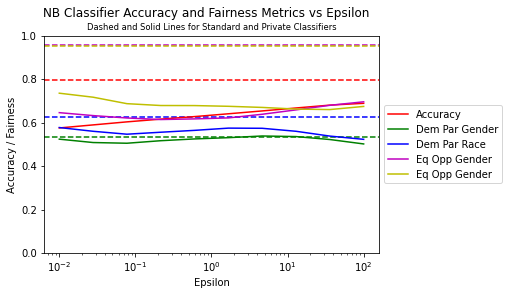

In [9]:
plot_params(X_train, y_train, X_test, y_test, 50, 'NB')

100%|███████████████████████████████████████████| 50/50 [10:21<00:00, 12.43s/it]


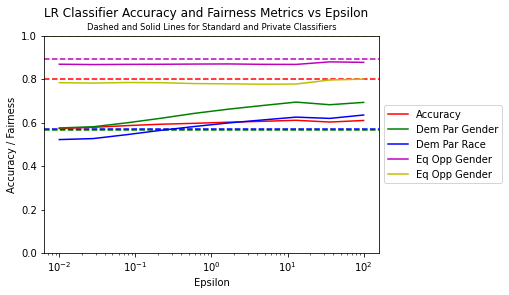

In [10]:
plot_params(X_train, y_train, X_test, y_test, 50, 'LR')